# Bagging of XGBoost Classifiers with Random Under-sampling and Tomek Link for Noisy Label-imbalanced Data
Inspired by Ruisen et al:
https://www.researchgate.net/publication/328005489_Bagging_of_Xgboost_Classifiers_with_Random_Under-sampling_and_Tomek_Link_for_Noisy_Label-imbalanced_Data

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.under_sampling import TomekLinks
import random
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

## Import data

In [47]:
df = pd.read_csv('/Users/Brian/Dropbox/Data Science/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Data preprocessing

In [48]:
#define response variable
y = pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index)
df.insert(0,'y', pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index))

In [50]:
#drop non predictive columns
df = df.drop(['Attrition_Flag','CLIENTNUM'],axis=1)
df = df.iloc[:,0:-2]

,y,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [51]:
#get dummies on all categorical variables to create new numerical columns, then drop original columns
categorical_features = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[categorical_features], prefix_sep='_')
X = pd.merge(df,X,how='outer',left_index=True,right_index=True)
X = X.drop(categorical_features, axis=1)
X.head()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,0,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,0,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,0,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,0,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [86]:
#Notice the imbalance in classes: only 15% of samples are positive
X['y'].value_counts()

0    8500
1    1627
Name: y, dtype: int64

## xgboost with Random Undersampling, Tomek Link Elimination, and model Bagging (XGB-RUTLEB)
Proven effective for highly noisy, class imbalanced data. Let's see how it performs on this dataset with 15% positive class (imbalanced, but not extremely so)

AUC Score0 : 0.9907880275498242 Accuracy:  0.9486673247778875
AUC Score1 : 0.9909968493552168 Accuracy:  0.9550839091806516
AUC Score2 : 0.9888152110199295 Accuracy:  0.9481737413622903
AUC Score3 : 0.9916343053927315 Accuracy:  0.9506416584402764
AUC Score4 : 0.9904308323563893 Accuracy:  0.947680157946693
AUC Score5 : 0.991623314771395 Accuracy:  0.956071076011846
AUC Score6 : 0.9898703106682298 Accuracy:  0.9501480750246791
AUC Score7 : 0.9899362543962485 Accuracy:  0.9461994076999013
AUC Score8 : 0.990146907971864 Accuracy:  0.9461994076999013
AUC Score9 : 0.9926472743259085 Accuracy:  0.9521224086870681

 Feature importance
Total_Trans_Ct              63.015182
Total_Revolving_Bal         34.197529
Total_Relationship_Count    18.186495
Total_Trans_Amt             13.314038
Total_Ct_Chng_Q4_Q1          8.858094
Months_Inactive_12_mon       7.696218
Total_Amt_Chng_Q4_Q1         7.146886
Avg_Open_To_Buy              6.919207
Gender_F                     6.388800
Name: cum_imp, dtype:

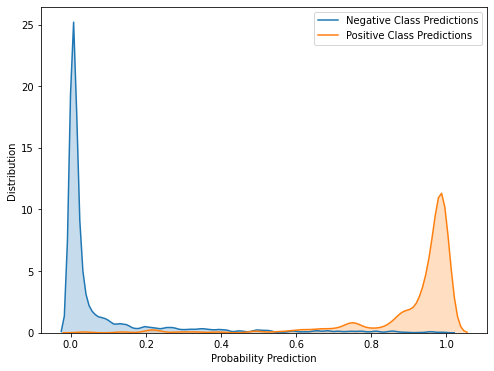

In [81]:
def xgbag(X, y, n):
    
    #test train split
    X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, y, test_size = 0.20,random_state = 12)
    
    #drop target column from test set
    X_Val = X_Val.drop('y',axis=1)

    #random sampling with replacement only on majority class
    X_Train_0 = X_Train[X_Train['y'] == 0]
    X_Train_1 = X_Train[X_Train['y'] == 1]
    
    #create dataframe for results
    yt = Y_Val.to_numpy()
    global bg
    bg = pd.DataFrame(data=yt, index=None, columns=['y'])
    global bg_test
    bg_test = pd.DataFrame(data=[], index=None, columns=[])

    #create dataframe for feature importances
    global importance
    importance = pd.DataFrame(data=None, index=X_Val.columns)

    #loop to execute steps 1-3
    for i in range(n):
        #create random samples from majority class
        X_Train_0_sample = X_Train_0.sample(2000)
        
        #combine random sample with minority class
        X_Train_sample = pd.concat([X_Train_0_sample, X_Train_1])
        
        #tomek links undersampling to remove links (assumes target variable is in first column)
        tl = TomekLinks(sampling_strategy='majority')
        X_Train_res1, Y_Train_res1 = tl.fit_resample(X_Train_sample.iloc[:,1:], X_Train_sample.iloc[:,0])
        
        #run xgboost model
        est1 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
        eval_set = [(X_Val,Y_Val)]
        est1.fit(X_Train_res1, Y_Train_res1) #early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

        val_preds = est1.predict_proba(X_Val)
        val_class_preds = est1.predict(X_Val)
        auc_prob_val = roc_auc_score(Y_Val, val_preds[:,1])
        accuracy = accuracy_score(Y_Val, val_class_preds)
        print('AUC Score%s :'%i, auc_prob_val, 'Accuracy: ', accuracy)
        
        #test_preds = est1.predict_proba(X_test)

        #append predictions to results dataframe
        bg['pred%s' %i] = val_preds[:,1]
        #bg_test['pred%s' %i] = test_preds[:,1]
        
        #get most important features
        f = 'gain'
        g = est1.get_booster().get_score(importance_type= f)
        j = pd.Series(g).to_frame()        
        importance = importance.merge(j,how='outer',left_index=True, right_index=True)

    # 4 - bagging classifiers i.e. take average of predictions for each row in test data
    col = bg.loc[: , "pred0":"pred%s"%i]
    bg['cum_prob'] = col.mean(axis=1)
    bg['cum_pred'] = np.where(bg['cum_prob'] > 0.5, 1, 0)
    
    bg_test['cum_prob'] = col.mean(axis=1)
    
    print('\n','Feature importance')
    col2 = importance.iloc[: , 0:n]
    importance['cum_imp'] = col2.mean(axis=1)
    importance = importance.sort_values(by=['cum_imp'], ascending=False)
    print(importance['cum_imp'][0:9])

    #print results
    print('\n','Confusion Matrix','\n',confusion_matrix(bg['y'], bg['cum_pred']))
    print('\n','Classification Report', '\n', classification_report(bg['y'], bg['cum_pred'], digits=3))
    auc_prob = roc_auc_score(bg['y'], bg['cum_prob'])
    print('\n','ROC AUC Score : ',auc_prob)
    
    #plot probabilities 
    pr_pos = bg[bg['y'] == 1]
    pr_neg = bg[bg['y'] == 0]

    plt.figure(figsize=(8,6))
    #plt.hist([pr_neg['cum_prob'], pr_pos['cum_prob']], bins=20, alpha=0.5, density=True)
    sns.set_style()
    sns.kdeplot(pr_neg['cum_prob'], shade=True, label = 'Negative Class Predictions')
    sns.kdeplot(pr_pos['cum_prob'], shade=True, label = 'Positive Class Predictions')
    plt.ylabel('Distribution', fontsize=10)
    plt.xlabel('Probability Prediction', fontsize=10)

    
       
xgbag(X,y,10)

### Now let's run a standard xgboost model and compare the outputs

In [87]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, y, test_size = 0.20,random_state = 12)
X_Val = X_Val.drop('y',axis=1)
X_Train = X_Train.drop('y',axis=1)


#run xgboost model
est = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Val,Y_Val)]
est.fit(X_Train, Y_Train) #early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

val_preds = est.predict_proba(X_Val)
val_class_preds = est.predict(X_Val)
auc_prob_val = roc_auc_score(Y_Val, val_preds[:,1])
accuracy = accuracy_score(Y_Val, val_class_preds)
print('AUC Score :', auc_prob_val, 'Accuracy: ', accuracy)
print('\n','Confusion Matrix','\n',confusion_matrix(Y_Val, val_class_preds))
print('\n','Classification Report', '\n', classification_report(Y_Val, val_class_preds, digits=3))


AUC Score : 0.9937206916764361 Accuracy:  0.9723593287265548

 Confusion Matrix 
 [[1691   15]
 [  41  279]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.976     0.991     0.984      1706
           1      0.949     0.872     0.909       320

    accuracy                          0.972      2026
   macro avg      0.963     0.932     0.946      2026
weighted avg      0.972     0.972     0.972      2026



## Summary

We  see that both the XGB-RUTLED and regular XGBoost model performs about equally well in terms of ROC AUC with scores of 99%+.  The main difference is in the Precision and Recall for identifying the positive class, which is an important tradeoff to consider in this case of credit card customers leaving the bank and in just about every other application.

As a reminder, Precision is telling us what proportion of positive identifications was actually correct: TP/(TP+FP), while Recall is telling us what proportion of actual positives were we able to correctly predict: TP/(TP+FN).

Regular xgb: Recall: 87.2%, Precision: 94.9%
XGB-RUTLED : Recall: 96.6%, Precision: 78.8%

So, our model with random undersampling, tomek link elimination, and model bagging results in better recall but lower precision.  This makes sense, as the steps taken to normalize the positive and negative classes (undersampling, tomek link elimination) should result in a model with better ability to predict the minor (positive) class.  

In practical terms, this means the model is better at predicting the actual positives of customers leaving the bank, at the expense of more false positives.  The bank will need to determine if the cost of a false positive (i.e. offering extra services to customers who were not actually at risk of leaving) outweighs the cost of a false negative (i.e. losing a customer) in order to decide which model to use in production. My intuition is that a false negative is going to be more costly, so overall this serves as a nice example of how this unique approach to dealing with noisy, class imbalanced data can be valuable. 